# Rede Hidrometeorológica Nacional

## Espacialização de dados de precipitação na bacia hidrográfica

Trabalhando com os dados da Rede Hidrometeorológica Nacional, da Agência Nacional de Águas (ANA).

## Importando bibliotecas

In [1]:
import requests
import zipfile
from pathlib import Path
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import seaborn as sns
from shapely import geometry, ops
import fiona
import geopandas as gpd
from datetime import datetime, timedelta
from calendar import monthrange

In [2]:
# # Atualizar o Google Download
# !pip install --upgrade --no-cache-dir gdown

Baixar o arquivo com todos os shapefiles criados no notebook Aula 09a

* bacia
* hidro
* pluvio
* exuto

https://drive.google.com/file/d/1xRKJ98zwJeNMG53nj6kyW1Ijl_YqL3zT/view?usp=sharing

In [3]:
!gdown 1xRKJ98zwJeNMG53nj6kyW1Ijl_YqL3zT

Downloading...
From: https://drive.google.com/uc?id=1xRKJ98zwJeNMG53nj6kyW1Ijl_YqL3zT
To: /content/shapefiles.zip
100% 1.31M/1.31M [00:00<00:00, 40.0MB/s]


In [4]:
!unzip shapefiles.zip

Archive:  shapefiles.zip
   creating: content/shapefiles/
   creating: content/shapefiles/exuto/
  inflating: content/shapefiles/exuto/exuto.dbf  
  inflating: content/shapefiles/exuto/exuto.prj  
  inflating: content/shapefiles/exuto/exuto.shp  
  inflating: content/shapefiles/exuto/exuto.shx  
 extracting: content/shapefiles/exuto/exuto.cpg  
   creating: content/shapefiles/pluvio/
  inflating: content/shapefiles/pluvio/pluvio.shp  
  inflating: content/shapefiles/pluvio/pluvio.shx  
  inflating: content/shapefiles/pluvio/pluvio.prj  
 extracting: content/shapefiles/pluvio/pluvio.cpg  
  inflating: content/shapefiles/pluvio/pluvio.dbf  
   creating: content/shapefiles/bacia/
  inflating: content/shapefiles/bacia/bacia.shx  
 extracting: content/shapefiles/bacia/bacia.cpg  
  inflating: content/shapefiles/bacia/bacia.dbf  
  inflating: content/shapefiles/bacia/bacia.prj  
  inflating: content/shapefiles/bacia/bacia.shp  
   creating: content/shapefiles/hidro/
  inflating: content/shap

In [5]:
exuto = gpd.read_file('content/shapefiles/exuto/exuto.shp')
pluvio = gpd.read_file('content/shapefiles/pluvio/pluvio.shp')
bacia = gpd.read_file('content/shapefiles/bacia/bacia.shp')
hidro = gpd.read_file('content/shapefiles/hidro/hidro.shp')

## Fazer o download dos dados das estações

* CODIGOs: 865000, 869000, 1168001

Após o tratamento do CSV (notebook da Aula 09b).

Copiar e colar o arquivo CSV no seu Google Drive, compartilhar com 'qualquer pessoa com o link' e copir o link:

Importando os dados de precipitação

* prec_24_pluv.csv - https://drive.google.com/file/d/1aRyTD1G-bLrOqxUtBn_9mw5863_7JwKG/view?usp=sharing

In [6]:
# Extrair do link o código no meio das barras e fazer o download no servidor do google
!gdown 1aRyTD1G-bLrOqxUtBn_9mw5863_7JwKG

Downloading...
From: https://drive.google.com/uc?id=1aRyTD1G-bLrOqxUtBn_9mw5863_7JwKG
To: /content/prec_24_pluv.csv
100% 1.03M/1.03M [00:00<00:00, 60.0MB/s]


In [7]:
# leitura dos dados com pandas
df_pluv = pd.read_csv('prec_24_pluv.csv')

print(len(df_pluv))

11323


In [8]:
df_pluv['data'] = pd.to_datetime(df_pluv["data"])
df_pluv = df_pluv.set_index('data')

In [9]:
# Acumula dados anuais
df_prec_anual  = df_pluv.resample("Y").sum()

In [10]:
df_prec_anual

,1065002,1068000,1063000,967000,967002,966000,965001,963001,967001,968001,...,765000,772000,764003,770000,764001,669000,668000,664000,567001,466001
data,,,,,,,,,,,,,,,,,,,,,
1980-12-31,1484.2,1911.1,2140.7,1717.1,0.0,2373.5,2260.9,2314.7,0.00,2035.5,...,2320.6,2040.0,2251.2,1895.1,1880.8,1643.4,2683.6,432.3,2327.7,1954.0
1981-12-31,1895.9,1892.7,2290.8,1660.1,655.7,1690.0,1641.2,2130.1,0.00,1918.7,...,2600.8,1648.8,2283.3,5128.5,1680.3,1875.3,2457.8,3502.7,2731.3,2975.8
1982-12-31,1832.9,2000.7,2146.9,1761.7,1343.9,2072.3,1605.4,3025.7,0.00,2115.7,...,2615.4,1962.8,1871.2,5123.4,1057.2,405.5,2472.1,2781.8,2840.4,2518.8
1983-12-31,1160.1,1707.6,1698.7,1721.3,0.0,1370.6,1358.1,1242.4,0.00,1054.2,...,1982.0,1901.7,2340.0,2860.1,2417.2,1620.1,2149.4,2771.5,2210.3,0.0
1984-12-31,1941.0,2025.2,1722.0,2050.9,0.0,1974.1,1168.1,1733.5,0.00,1495.6,...,2708.1,2064.1,2851.8,4421.9,2948.6,1089.8,2170.7,4632.5,2719.7,0.0
1985-12-31,1817.0,2322.2,2030.2,2126.1,0.0,1476.3,1891.5,2315.0,0.00,1563.9,...,2967.9,1576.5,2111.6,2676.3,2536.9,1059.3,3254.6,4008.6,2571.6,0.0
1986-12-31,1816.7,1481.2,2457.9,2442.5,0.0,2079.7,2518.9,2053.2,0.00,1378.4,...,2466.9,2207.7,2259.4,2489.8,2609.5,1022.3,2635.2,257.2,2704.6,0.0
1987-12-31,1471.9,1663.4,2069.9,1711.6,0.0,2478.2,2185.1,2404.1,0.00,1500.1,...,2064.8,2512.3,1928.9,2556.5,2597.0,1807.2,2430.6,3861.2,2488.3,0.0
1988-12-31,1457.0,1801.2,1419.2,2340.1,0.0,1713.7,2352.6,2559.3,0.00,1725.6,...,2440.3,2414.2,2233.4,2455.4,2339.7,2322.8,2479.7,4020.0,2751.9,0.0


<ipython-input-11-7e6ca3b6aab0>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels = df_prec_anual['1065002'].index.year, rotation = 45, fontsize=8)


[]

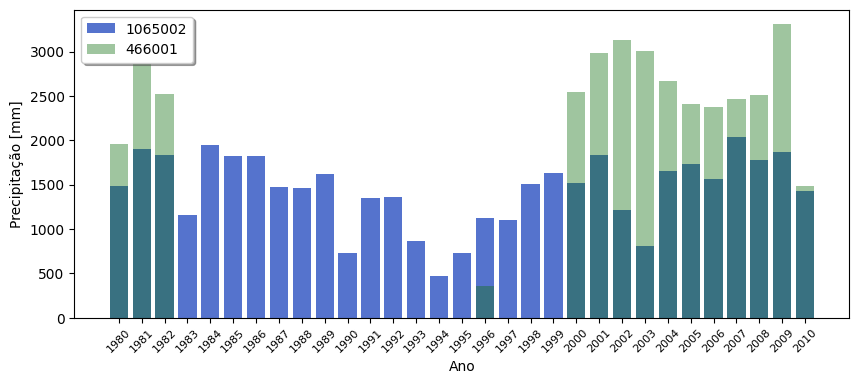

In [11]:
plt.figure(figsize=(10,4))
ax = sns.barplot(x=df_prec_anual['1065002'].index, y=df_prec_anual['1065002'], color = "royalblue",label='1065002')
ax = sns.barplot(x=df_prec_anual['466001'].index, y=df_prec_anual['466001'], color = "green",alpha = 0.4,label='466001')
#ax = sns.barplot(x=df_1168001_anual.index, y=df_1168001_anual["prec(mm)"], color = "red")
ax.set_xlabel("Ano")
ax.set_ylabel("Precipitação [mm]")
ax.set_xticklabels(labels = df_prec_anual['1065002'].index.year, rotation = 45, fontsize=8)
ax.legend(shadow=True, loc="upper left")
plt.plot()

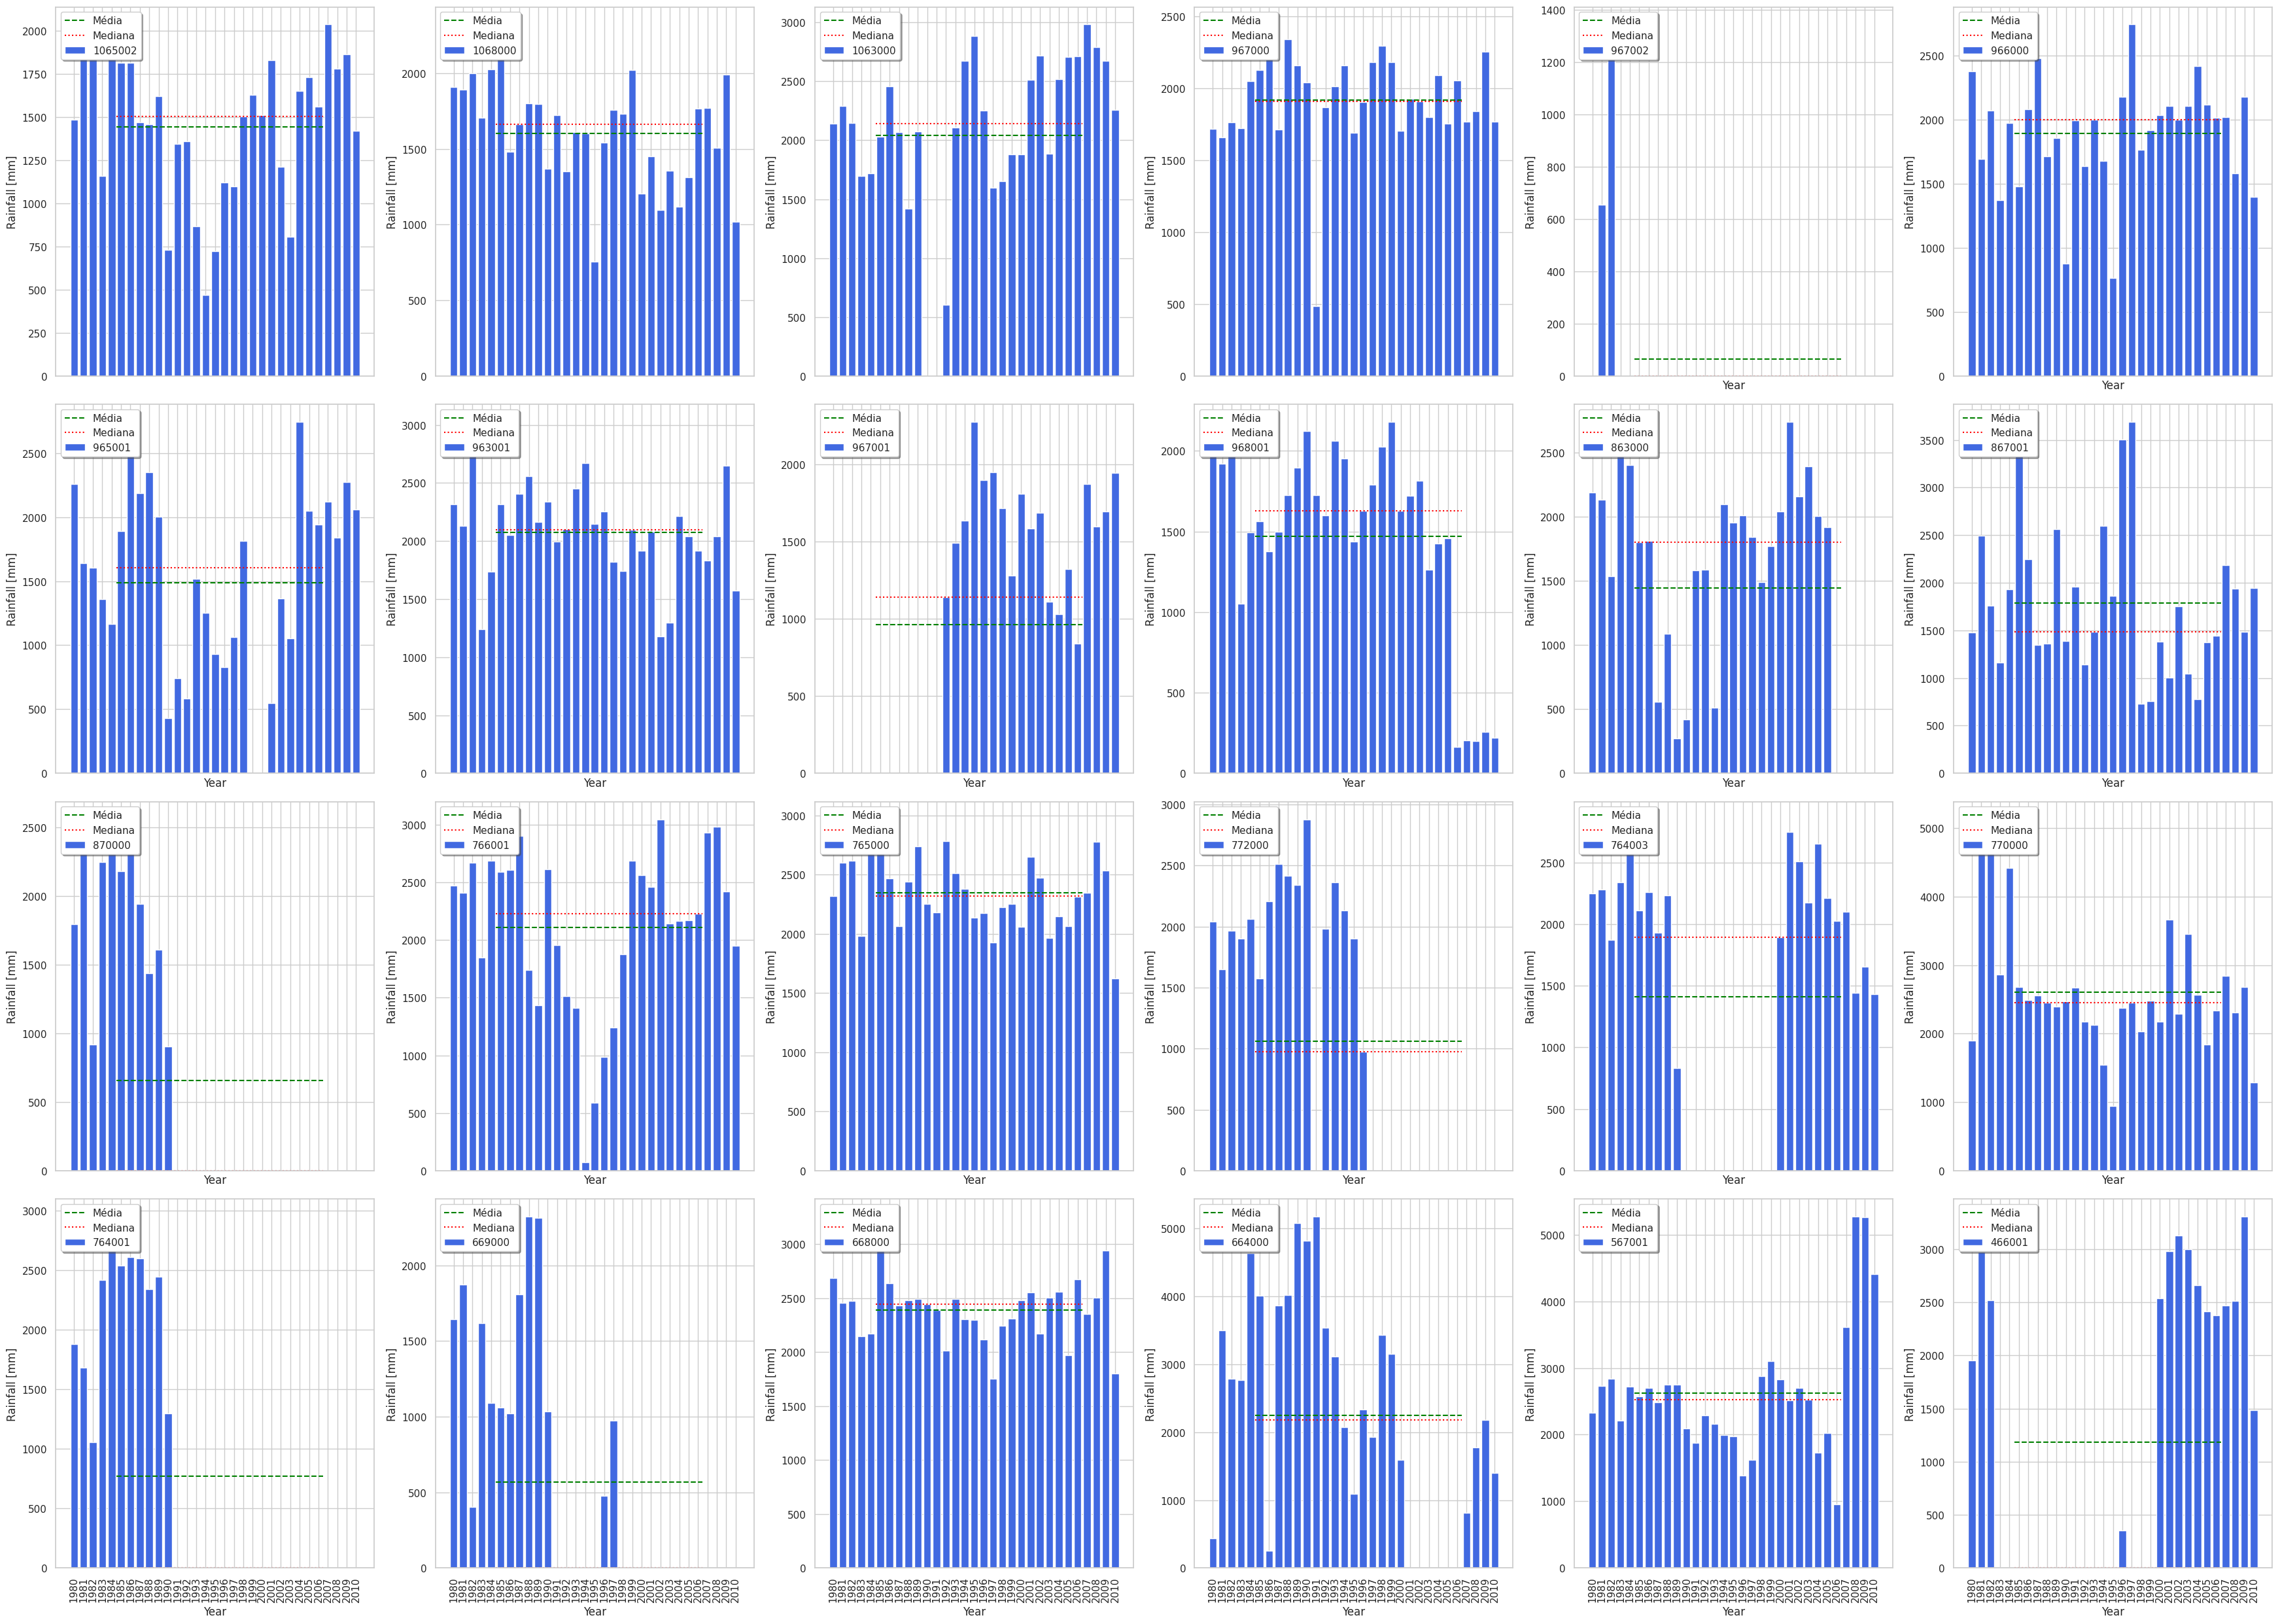

In [12]:
sns.set(style="whitegrid")

fig1, ax = plt.subplots(4,6, figsize = (35,25), tight_layout=True, sharex = True)

for i, (ax, value, name) in enumerate(zip(ax.flatten(), df_prec_anual.values.T, df_prec_anual.columns)):
    ax.set_xticks(df_prec_anual.index.year)
    ax.set_xticklabels(labels = df_prec_anual.index.year.values, rotation=90)
    ax.bar(df_prec_anual.index.year, df_prec_anual[name], label=name, color = "royalblue")

    ax.hlines(df_prec_anual[name].mean(), 1984.5, 2006.5, color="green", label="Média", ls = "--")
    ax.hlines(df_prec_anual[name].median(), 1984.5, 2006.5, color="red", label="Mediana", ls = ":")
    if i >3:
        ax.set_xlabel ("Year")
    ax.set_ylabel("Rainfall [mm]")
    #ax.set_ylim(0, 5000)
    ax.legend(shadow=True, loc="upper left")

plt.savefig('comparacao_24_pluv.png', dpi = 100, bbox_inches='tight')
plt.show();

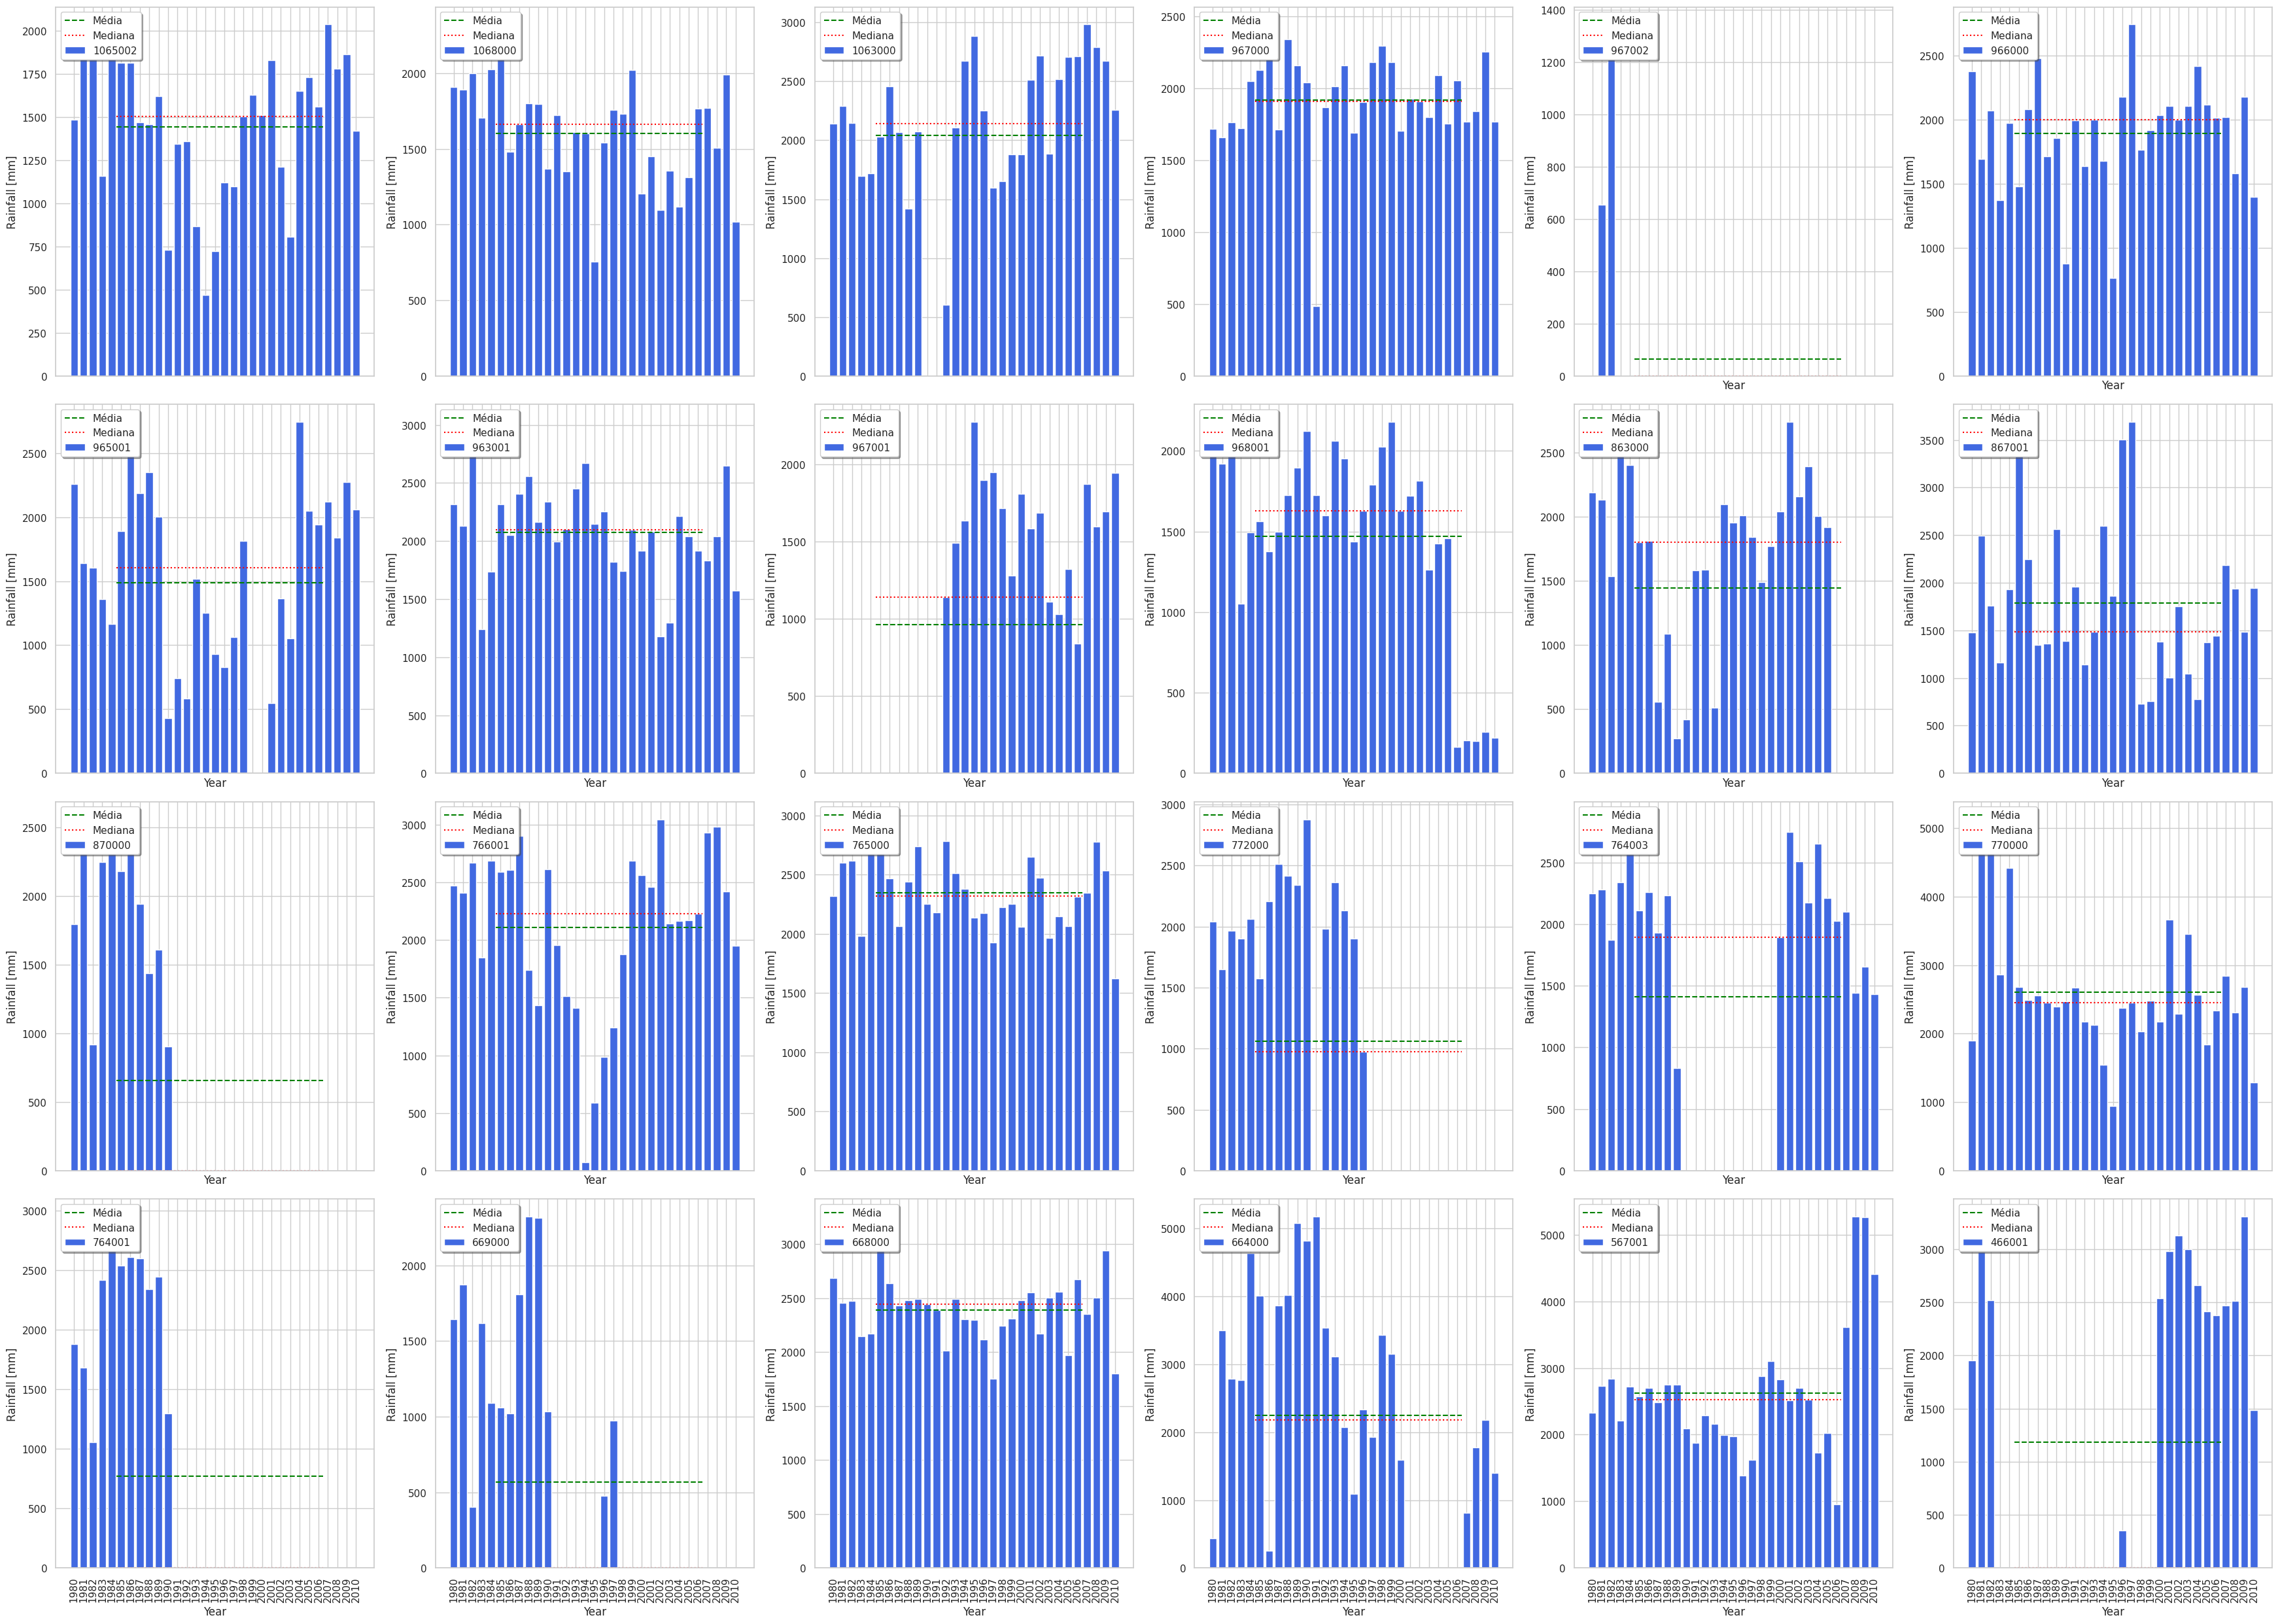

In [13]:
sns.set(style="whitegrid")

fig1, ax = plt.subplots(4,6, figsize = (35,25), tight_layout=True, sharex = True)

for i, (ax, value, name) in enumerate(zip(ax.flatten(), df_prec_anual.values.T, df_prec_anual.columns)):
    ax.set_xticks(df_prec_anual.index.year)
    ax.set_xticklabels(labels = df_prec_anual.index.year.values, rotation=90)
    ax.bar(df_prec_anual.index.year, df_prec_anual[name], label=name, color = "royalblue")

    ax.hlines(df_prec_anual[name].mean(), 1984.5, 2006.5, color="green", label="Média", ls = "--")
    ax.hlines(df_prec_anual[name].median(), 1984.5, 2006.5, color="red", label="Mediana", ls = ":")
    if i >3:
        ax.set_xlabel ("Year")
    ax.set_ylabel("Rainfall [mm]")
    #ax.set_ylim(0, 5000)
    ax.legend(shadow=True, loc="upper left")

plt.savefig('comparacao_24_pluv.png', dpi = 100, bbox_inches='tight')
plt.show();

In [14]:
pluvio

,CODIGO,geometry
0,1065002,POINT (-65.34780 -10.79250)
1,1068000,POINT (-68.50670 -10.64970)
2,1063000,POINT (-63.64610 -10.50500)
3,967002,POINT (-67.78330 -9.98330)
4,967000,POINT (-67.80000 -9.97580)
5,966000,POINT (-66.61170 -9.75560)
6,965001,POINT (-65.36470 -9.70310)
7,963001,POINT (-63.16190 -9.26060)
8,967001,POINT (-67.39690 -9.06670)
9,968001,POINT (-68.57720 -9.04390)


In [15]:
df_stats = df_prec_anual.describe().T
df_stats

,count,mean,std,min,25%,50%,75%,max
1065002,31.0,1443.825806,407.442201,468.9,1186.60,1503.9,1799.55,2037.2
1068000,31.0,1602.074194,345.408693,755.2,1363.05,1663.4,1798.40,2322.2
1063000,31.0,2043.490323,742.673532,0.0,1802.00,2140.7,2594.85,2982.8
967000,31.0,1914.954839,343.939306,487.5,1756.70,1909.9,2141.15,2442.5
967002,31.0,64.503226,265.017550,0.0,0.00,0.0,0.00,1343.9
966000,31.0,1889.954839,421.574169,763.2,1682.70,2000.1,2106.65,2740.9
965001,31.0,1488.380645,733.330031,0.0,993.15,1605.4,2054.40,2744.0
963001,31.0,2074.425806,412.022706,1179.6,1873.90,2099.1,2314.85,3025.7
967001,31.0,964.687742,830.403788,0.0,0.00,1142.4,1693.65,2277.3
968001,31.0,1469.980645,622.028220,164.8,1401.40,1629.9,1906.80,2180.4


In [16]:
# Selecionando apenas as estações que tiveram precipitação mínima em um ano > 500 mm
df_stats[df_stats['min']>500]

,count,mean,std,min,25%,50%,75%,max
1068000,31.0,1602.074194,345.408693,755.2,1363.05,1663.4,1798.40,2322.2
966000,31.0,1889.954839,421.574169,763.2,1682.70,2000.1,2106.65,2740.9
963001,31.0,2074.425806,412.022706,1179.6,1873.90,2099.1,2314.85,3025.7
867001,31.0,1787.858065,787.663740,731.3,1354.30,1486.3,2074.10,3690.1
765000,31.0,2345.125806,304.077957,1625.5,2143.45,2320.6,2567.55,2967.9
770000,31.0,2603.800000,932.397721,939.3,2174.35,2455.4,2679.65,5128.5
668000,31.0,2390.180645,303.330522,1752.8,2209.80,2443.5,2504.70,3254.6
567001,31.0,2623.641935,954.192034,959.2,2059.30,2523.1,2791.30,5271.0


In [17]:
selecionadas = df_stats[df_stats['min']>500].index.values
#selecionadas = df_stats.index.values
selecionadas = selecionadas.astype(int)
selecionadas = list(selecionadas)
selecionadas

[1068000, 966000, 963001, 867001, 765000, 770000, 668000, 567001]

In [18]:
pluvio_sel = pluvio.loc[pluvio['CODIGO'].isin(selecionadas)]
pluvio_sel

,CODIGO,geometry
1,1068000,POINT (-68.50670 -10.64970)
5,966000,POINT (-66.61170 -9.75560)
7,963001,POINT (-63.16190 -9.26060)
11,867001,POINT (-67.40030 -8.73560)
14,765000,POINT (-66.05830 -7.71560)
17,770000,POINT (-70.02250 -7.42810)
20,668000,POINT (-68.24390 -6.44170)
22,567001,POINT (-67.85690 -5.89360)


In [19]:
pos_x = pluvio_sel['geometry'].x.values
pos_y = pluvio_sel['geometry'].y
codes = list(pluvio_sel['CODIGO'])

pluvio_sel['lon'] = pos_x
pluvio_sel['lat'] = pos_y
pluvio_sel['name'] = codes
pluvio_sel

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,CODIGO,geometry,lon,lat,name
1,1068000,POINT (-68.50670 -10.64970),-68.5067,-10.6497,1068000
5,966000,POINT (-66.61170 -9.75560),-66.6117,-9.7556,966000
7,963001,POINT (-63.16190 -9.26060),-63.1619,-9.2606,963001
11,867001,POINT (-67.40030 -8.73560),-67.4003,-8.7356,867001
14,765000,POINT (-66.05830 -7.71560),-66.0583,-7.7156,765000
17,770000,POINT (-70.02250 -7.42810),-70.0225,-7.4281,770000
20,668000,POINT (-68.24390 -6.44170),-68.2439,-6.4417,668000
22,567001,POINT (-67.85690 -5.89360),-67.8569,-5.8936,567001


In [20]:
precip_basin = pd.DataFrame(df_prec_anual.mean(axis = 0)).rename_axis('name').reset_index().sort_values(by=["name"]).rename(columns = {0: "Mean"})
precip_basin

,name,Mean
2,1063000,2043.490323
0,1065002,1443.825806
1,1068000,1602.074194
23,466001,1183.470968
22,567001,2623.641935
21,664000,2250.945161
20,668000,2390.180645
19,669000,569.177419
18,764001,768.035484
16,764003,1413.212903


In [21]:
precip_basin['name'] = precip_basin['name'].astype(int)
precip_basin.dtypes

name      int64
Mean    float64
dtype: object

In [22]:
precip_basin_sel = precip_basin.loc[precip_basin['name'].isin(selecionadas)]
precip_basin_sel

,name,Mean
1,1068000,1602.074194
22,567001,2623.641935
20,668000,2390.180645
14,765000,2345.125806
17,770000,2603.800000
11,867001,1787.858065
7,963001,2074.425806
5,966000,1889.954839


In [23]:
meteo_loc = pd.merge(pluvio_sel, precip_basin_sel, on="name")
meteo_loc

,CODIGO,geometry,lon,lat,name,Mean
0,1068000,POINT (-68.50670 -10.64970),-68.5067,-10.6497,1068000,1602.074194
1,966000,POINT (-66.61170 -9.75560),-66.6117,-9.7556,966000,1889.954839
2,963001,POINT (-63.16190 -9.26060),-63.1619,-9.2606,963001,2074.425806
3,867001,POINT (-67.40030 -8.73560),-67.4003,-8.7356,867001,1787.858065
4,765000,POINT (-66.05830 -7.71560),-66.0583,-7.7156,765000,2345.125806
5,770000,POINT (-70.02250 -7.42810),-70.0225,-7.4281,770000,2603.800000
6,668000,POINT (-68.24390 -6.44170),-68.2439,-6.4417,668000,2390.180645
7,567001,POINT (-67.85690 -5.89360),-67.8569,-5.8936,567001,2623.641935


In [24]:
len(pluvio_sel), len(precip_basin_sel)

(8, 8)

In [25]:
limites = bacia['geometry'].bounds
#limites

In [26]:
bacia['minx'] = limites['minx'].values[0]
bacia['miny'] = limites['miny'].values[0]
bacia['maxx'] = limites['maxx'].values[0]
bacia['maxy'] = limites['maxy'].values[0]

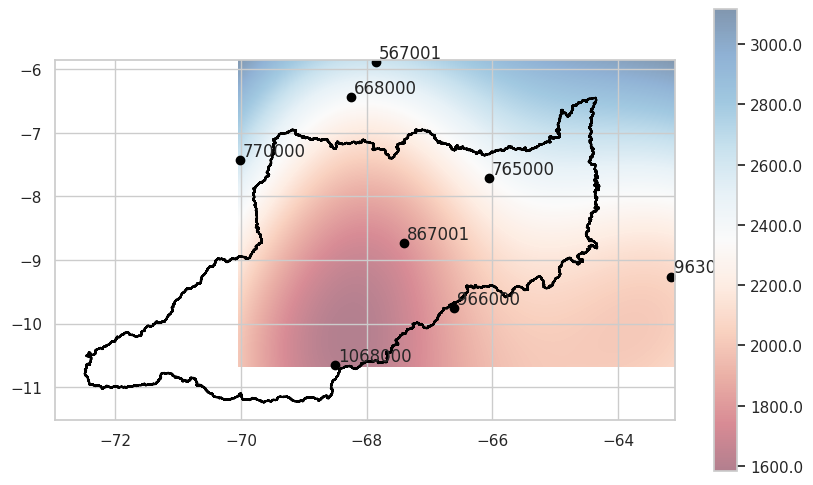

In [27]:
# Plot all the catchment and hidrometric station
meteo_loc = pd.merge(pluvio_sel, precip_basin_sel, on="name")
#generate the desired grid, where rainfall is to be interpolated
X,Y = np.meshgrid(np.linspace(meteo_loc["lon"].min()-0.05,meteo_loc["lon"].max()+0.05,2000), np.linspace(meteo_loc["lat"].min()-0.05,meteo_loc["lat"].max()+0.05,2000))
#X,Y = np.meshgrid(np.linspace(bacia['minx'].values-0.05,bacia['maxx'].values+0.05,2000), np.linspace(bacia['miny'].values-0.05,bacia['maxy'].values+0.05,2000))

#perform the interpolation
grid_rain = sp.interpolate.Rbf(meteo_loc["lon"],meteo_loc["lat"], meteo_loc["Mean"])

spatial_rain = grid_rain(X,Y)

fig, ax = plt.subplots(figsize = (10, 6))

gg = ax.imshow(spatial_rain, extent = (meteo_loc["lon"].min()-0.02,meteo_loc["lon"].max()+0.07, meteo_loc["lat"].min()-0.03,meteo_loc["lat"].max()+0.03 ), cmap=cm.RdBu, alpha = 0.5, origin = 'lower')
ax.scatter(meteo_loc["lon"], meteo_loc["lat"], color = "black")
for i, (x,y) in enumerate(zip (meteo_loc["lon"], meteo_loc["lat"])):
    label = meteo_loc["name"][i]
    ax.annotate(label, (x,y), textcoords = "offset points", xytext = (2,3))

bacia.geometry.boundary.plot(ax = ax, alpha = 1, color = None, edgecolor =  "black")
fig.colorbar(gg, format = '%.1f')

In [28]:
exuto.columns

Index(['EST_ID', 'REGISTROID', 'BACIA', 'RIO', 'ESTADO', 'MUNICIPIO',
       'RESPONSAVE', 'OPERADORA', 'OPERADORA_', 'ROTEIRO', 'TIPOESTACA',
       'CODIGO', 'NOME', 'LATITUDE', 'LONGITUDE', 'AREADRENAG', 'OPERANDO',
       'TIPOESTA_1', 'TIPOESTA_2', 'TIPOESTA_3', 'TIPOESTA_4', 'TIPOESTA_5',
       'TIPOESTA_6', 'TIPOESTA_7', 'TIPOESTA_8', 'TIPOESTA_9', 'TIPOEST_10',
       'TIPOREDEBA', 'TIPOREDEEN', 'TIPOREDENA', 'TIPOREDECU', 'TIPOREDEES',
       'TIPOREDECA', 'TIPOREDESE', 'TIPOREDEQU', 'TIPOREDECL', 'PERIODOESC',
       'PERIODOREG', 'PERIODODES', 'PERIODOSED', 'PERIODOQUA', 'PERIODOPLU',
       'PERIODOR_1', 'PERIODOTAN', 'PERIODOCLI', 'PERIODOTEL', 'geometry'],
      dtype='object')

In [29]:
exuto2 = exuto[['CODIGO', 'NOME','LATITUDE', 'LONGITUDE','geometry']]
exuto2

,CODIGO,NOME,LATITUDE,LONGITUDE,geometry
0,13880000,CANUTAMA,-6.5389,-64.3858,POINT (-64.38580 -6.53890)


# Pluviômetros escolhidos para a análise

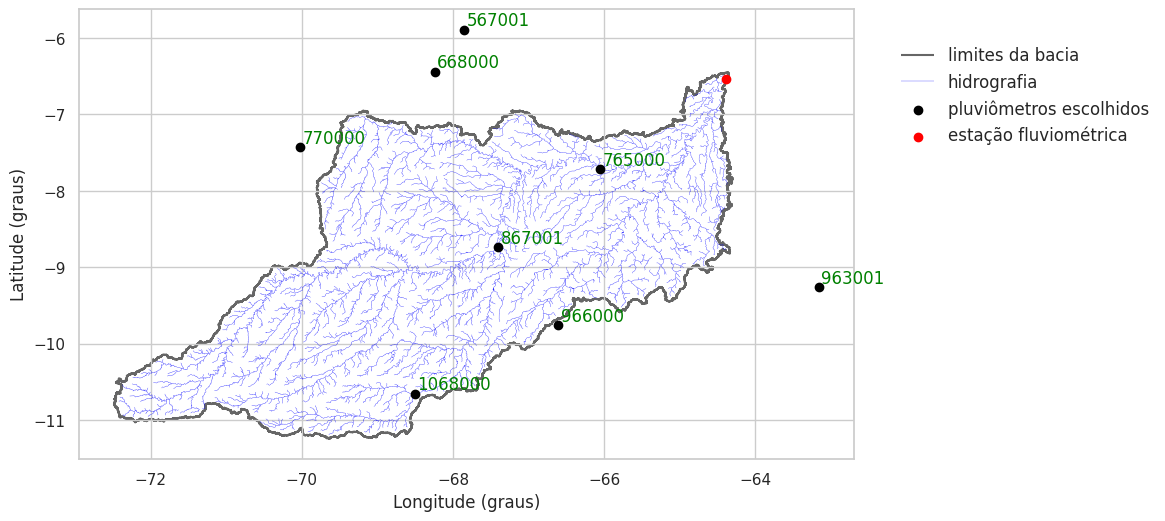

In [30]:
fig, ax = plt.subplots(figsize = (10, 6))

bacia.geometry.boundary.plot(ax = ax, alpha = 0.6, color = None, edgecolor =  "black", label = 'limites da bacia',zorder=0)
hidro.plot(ax=ax,color='blue', linewidth=0.2, label = 'hidrografia',zorder=1)
ax.scatter(meteo_loc["lon"], meteo_loc["lat"], color = "black", label = 'pluviômetros escolhidos',zorder=2)
for i, (x,y) in enumerate(zip (meteo_loc["lon"], meteo_loc["lat"])):
    label = meteo_loc["name"][i]
    ax.annotate(label, (x,y), textcoords = "offset points", xytext = (2,3), color = "green")

plt.xlabel('Longitude (graus)')
plt.ylabel('Latitude (graus)')

ax.scatter(exuto2['LONGITUDE'], exuto2['LATITUDE'], color = "red", label = 'estação fluviométrica',zorder=3)

plt.legend(loc="upper right",bbox_to_anchor=(1.4, 0.95), frameon=False, fontsize=12)

# Show the plot
plt.savefig('pluviometros_escolhidos.png', dpi = 200, bbox_inches='tight')
#plt.savefig('Mutations_bars_correlation.pdf', dpi = 600, bbox_inches='tight')
plt.show();

## Exportar os resultados

1. Dados diários das Estações escolhidas

In [31]:
selecionadas

[1068000, 966000, 963001, 867001, 765000, 770000, 668000, 567001]

In [32]:
lista_selecionadas_string = []
for i in range(len(selecionadas)):
  lista_selecionadas_string.append(str(selecionadas[i]))

lista_selecionadas_string

['1068000',
 '966000',
 '963001',
 '867001',
 '765000',
 '770000',
 '668000',
 '567001']

In [33]:
df_pluv.columns

Index(['1065002', '1068000', '1063000', '967000', '967002', '966000', '965001',
       '963001', '967001', '968001', '863000', '867001', '870000', '766001',
       '765000', '772000', '764003', '770000', '764001', '669000', '668000',
       '664000', '567001', '466001'],
      dtype='object')

In [34]:
# Selecionar apenas as colunas de interesse
df_pluv_sel = df_pluv[df_pluv.columns.intersection(lista_selecionadas_string)]
df_pluv_sel

,1068000,966000,963001,867001,765000,770000,668000,567001
data,,,,,,,,
1980-01-01,20.5,20.6,0.0,18.0,15.2,0.0,30.4,4.4
1980-01-02,0.0,0.0,0.0,0.0,16.4,0.0,0.0,22.6
1980-01-03,0.0,0.0,2.2,0.0,0.0,0.0,0.0,23.8
1980-01-04,0.0,1.0,6.4,14.0,0.0,10.3,0.0,0.0
1980-01-05,0.0,1.2,0.6,0.0,5.2,21.1,0.0,0.0
...,...,...,...,...,...,...,...,...
2010-12-27,0.0,0.0,0.0,3.1,1.6,0.0,11.3,56.3
2010-12-28,0.0,66.2,39.0,0.0,0.7,0.0,0.0,41.0
2010-12-29,0.0,0.0,0.0,NaN,0.0,0.0,0.0,33.0


<Axes: xlabel='data'>

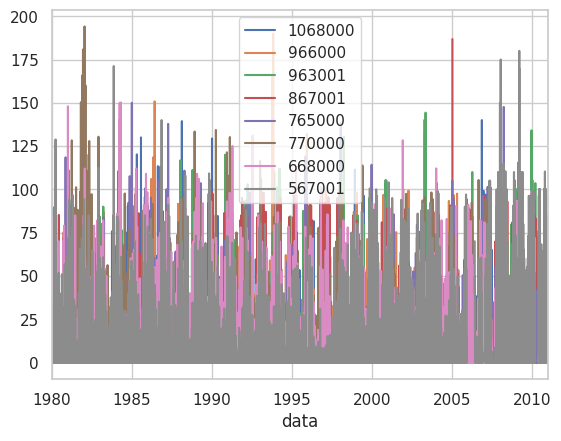

In [35]:
df_pluv_sel.plot()

In [36]:
df_pluv_sel.to_csv('prec_8_pluv_sel.csv')

In [37]:
pluvio_sel

,CODIGO,geometry,lon,lat,name
1,1068000,POINT (-68.50670 -10.64970),-68.5067,-10.6497,1068000
5,966000,POINT (-66.61170 -9.75560),-66.6117,-9.7556,966000
7,963001,POINT (-63.16190 -9.26060),-63.1619,-9.2606,963001
11,867001,POINT (-67.40030 -8.73560),-67.4003,-8.7356,867001
14,765000,POINT (-66.05830 -7.71560),-66.0583,-7.7156,765000
17,770000,POINT (-70.02250 -7.42810),-70.0225,-7.4281,770000
20,668000,POINT (-68.24390 -6.44170),-68.2439,-6.4417,668000
22,567001,POINT (-67.85690 -5.89360),-67.8569,-5.8936,567001


In [38]:
!mkdir shapefiles

!mkdir shapefiles/bacia
!mkdir shapefiles/hidro
!mkdir shapefiles/pluvio
!mkdir shapefiles/exuto

In [39]:
bacia.to_file('shapefiles/bacia/bacia.shp')
hidro.to_file('shapefiles/hidro/hidro.shp')
pluvio_sel.to_file('shapefiles/pluvio/pluvio_sel.shp')
exuto.to_file('shapefiles/exuto/exuto.shp')

In [40]:
!zip -r /content/shapefiles_pluvio_sel.zip /content/shapefiles/

  adding: content/shapefiles/ (stored 0%)
  adding: content/shapefiles/exuto/ (stored 0%)
  adding: content/shapefiles/exuto/exuto.prj (deflated 17%)
  adding: content/shapefiles/exuto/exuto.dbf (deflated 90%)
  adding: content/shapefiles/exuto/exuto.shp (deflated 65%)
  adding: content/shapefiles/exuto/exuto.shx (deflated 60%)
  adding: content/shapefiles/exuto/exuto.cpg (stored 0%)
  adding: content/shapefiles/bacia/ (stored 0%)
  adding: content/shapefiles/bacia/bacia.cpg (stored 0%)
  adding: content/shapefiles/bacia/bacia.dbf (deflated 64%)
  adding: content/shapefiles/bacia/bacia.shp (deflated 41%)
  adding: content/shapefiles/bacia/bacia.prj (deflated 17%)
  adding: content/shapefiles/bacia/bacia.shx (deflated 45%)
  adding: content/shapefiles/pluvio/ (stored 0%)
  adding: content/shapefiles/pluvio/pluvio_sel.dbf (deflated 70%)
  adding: content/shapefiles/pluvio/pluvio_sel.shp (deflated 40%)
  adding: content/shapefiles/pluvio/pluvio_sel.cpg (stored 0%)
  adding: content/shapef

In [41]:
from google.colab import files
files.download("/content/shapefiles_pluvio_sel.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>